# Skim Imputed Data

In the TrackMan era of StatCast, it was common for certain batted balls not to be picked up by the system, as many as 20-30% in the early years. In order to navigate this, StatCast implemented the "no-nulls" approach, in which certain values of launch angle and exit velocity are imputed into the dataset depending on where the ball landed, the batted ball type, the result, and which player fielded the ball. See [this post](https://tht.fangraphs.com/43416-2/) for more details.

This imputation can cause non-physical effects in the dataset, so this example will show you how to filter out imputed data so it doesn't bias your sample.

In [1]:
from pybaseball import statcast, utils
import matplotlib.pyplot as plt
import numpy as np

First, load an arbitrary, but large, dataset from the 2018 season to work with

In [2]:
data = statcast(
    start_dt='2018-03-29',
    end_dt='2018-06-05',
    verbose=False
)

This is a large query, it may take a moment to complete


First, to highlight the problem, take a look at the exit velocity and launch angle distributions before filtering out any of the imputed values.

In [3]:
# Look at only batted balls
bb_data = data[~data["bb_type"].isna()]

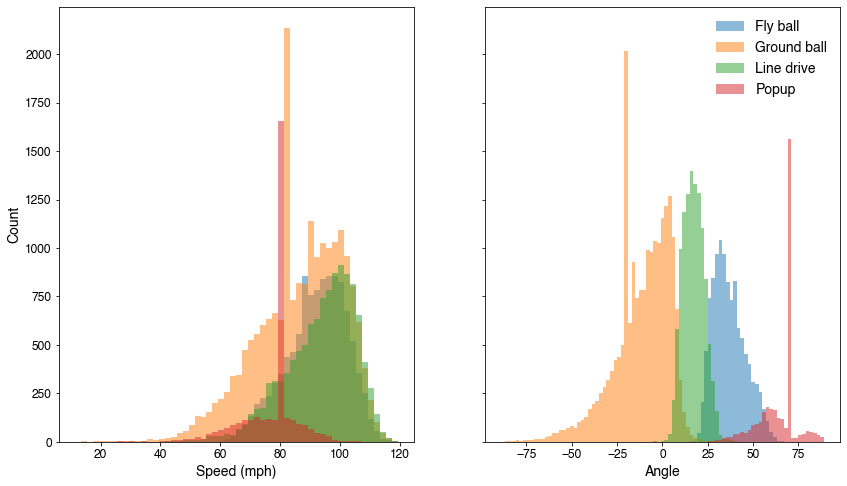

In [4]:
bb_types = bb_data.bb_type.dropna().unique()

# Setup figure
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(14,8))

# Generic plotting routine separated by bb_type
def plot_by_type(bb_type, df, col):
    df_skimmed = df[df.bb_type == bb_type]
    bins = np.arange(df[col].min(),df[col].max(),2)
    plt.hist(df_skimmed[col], bins=bins, alpha=0.5, label=bb_type.replace("_"," ").capitalize())
    plt.tick_params(labelsize=12)

# Launch Speed Plot
plt.sca(ax1)
for bb_type in bb_types:
    plot_by_type(bb_type, bb_data,"launch_speed")
plt.xlabel("Speed (mph)",fontsize=14)
plt.ylabel("Count",fontsize=14)

# Launch Angle Plot
plt.sca(ax2)
for bb_type in bb_types:
    plot_by_type(bb_type, bb_data,"launch_angle")
plt.xlabel("Angle",fontsize=14)

_=plt.legend(fontsize=14, frameon=False)

Clearly, this is problematic if you intend on doing any sort of analysis of these parameters. On the flip side, if you're doing analysis on these, you probably have a large sample set, so removing these imputations isn't catastrophic.

Pybaseball now includes methods for flagging possibly imputed data, the function `flag_imputed_data` within utils. Pass the StatCast dataframe to this function, and it will add a new column indicating if an even is likely imputed.

In [5]:
# Flag imputations
bb_data_flagged = utils.flag_imputed_data(bb_data)

# Print summary
imputation_count = bb_data_flagged["possible_imputation"].sum()
print(f"There are {imputation_count} imputations.")
print(f"This makes up {round(100*float(imputation_count)/len(bb_data_flagged),1)}% of your data")

There are 3221 imputations.
This makes up 6.9% of your data


Now, dropping out those imputations is as simple as a boolean dataframe slice

In [6]:
# Create an imputation-free dataframe
bb_data_clean = bb_data_flagged[~bb_data_flagged["possible_imputation"]]

Plotting the new, clean data

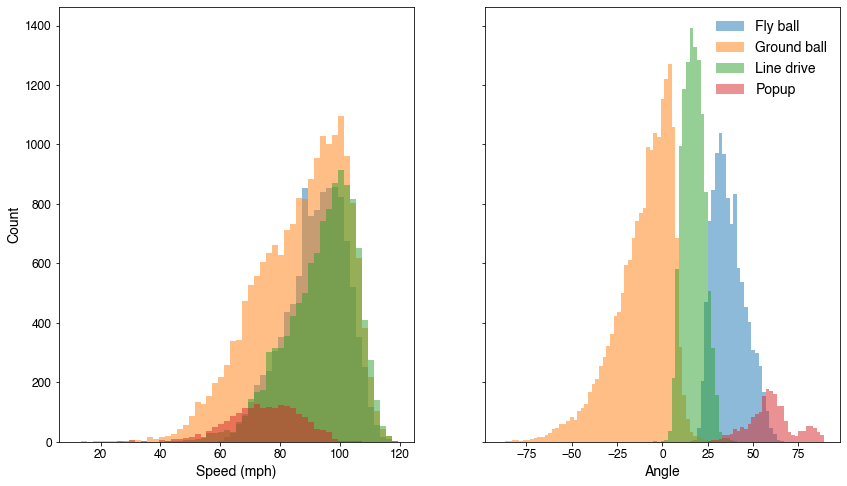

In [7]:
# Setup figure
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(14,8))

# Launch Speed Plot
plt.sca(ax1)
for bb_type in bb_types:
    plot_by_type(bb_type, bb_data_clean,"launch_speed")
plt.xlabel("Speed (mph)",fontsize=14)
plt.ylabel("Count",fontsize=14)

# Launch Angle Plot
plt.sca(ax2)
for bb_type in bb_types:
    plot_by_type(bb_type, bb_data_clean,"launch_angle")
plt.xlabel("Angle",fontsize=14)

_=plt.legend(fontsize=14, frameon=False)